In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

import matplotlib.pyplot as plt


In [2]:
# GPU or CPU device to use
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


In [3]:
# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(), # randomly flip and rotate
    transforms.RandomRotation(10),
    transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# choose the training and test datasets
train_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False,
                             download=True, transform=transform)

# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Files already downloaded and verified
Files already downloaded and verified


In [4]:
# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=512, num_workers=1)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=16, num_workers=1)


In [5]:
batch = next(iter(test_loader))
data, target = batch
print(target)

tensor([3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9, 8])


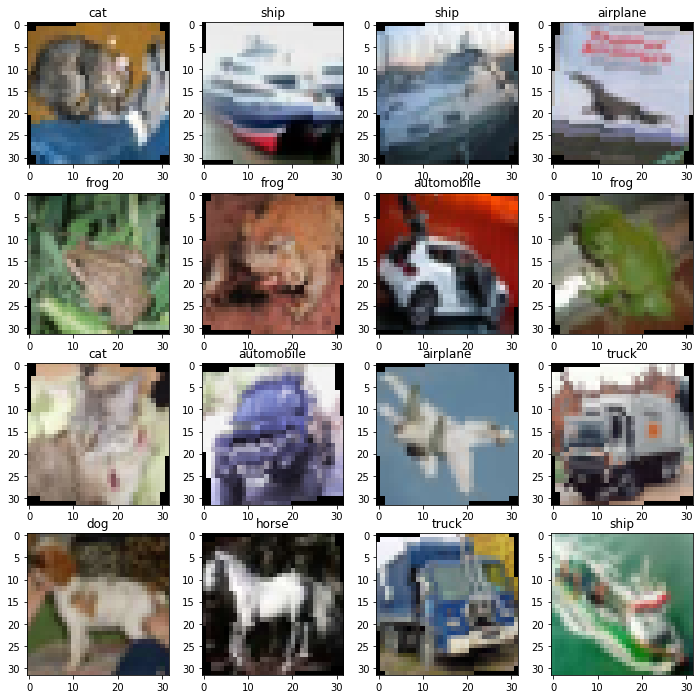

In [6]:
_data = data.data.cpu().numpy()

plt.figure(figsize=[12, 12])
for i in range(16):
    plt.subplot(4, 4, i+1)
    clazz = classes[target[i].item()]
    plt.title(clazz)
    plt.imshow(np.transpose(_data[i], (1, 2, 0)))
plt.show()


In [7]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.convs = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
                                   nn.ReLU(),
                                   nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3),
                                   nn.ReLU(),
                                   nn.MaxPool2d(kernel_size=2),
                                   nn.Dropout(p=0.25),
                                   
                                   nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
                                   nn.ReLU(),
                                   nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3),
                                   nn.ReLU(),
                                   nn.MaxPool2d(kernel_size=2),
                                   nn.Dropout(p=0.25))
        
        self.linears = nn.Sequential(nn.Linear(in_features=64 * 6 * 6, out_features=512),
                                     nn.ReLU(),
                                     nn.Dropout(p=0.5),
                                     nn.Linear(in_features=512, out_features=10))
        
    def forward(self, x, t):
        '''
        x : [batch, channel=3, width=32, height=32]
        t : [batch]
        '''
        
        # [batch, channel, width, height]
        y = self.convs(x)
        # [batch, feature]
        y = y.view(-1, 64 * 6 * 6)
        # [batch, class]
        y = self.linears(y)
        
        return y


In [8]:
t = torch.randn(1, 3, 32, 32)
t = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
                                   nn.ReLU(),
                                   nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3),
                                   nn.ReLU(),
                                   nn.MaxPool2d(kernel_size=2),
                                   nn.Dropout(p=0.25),
                                   
                                   nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
                                   nn.ReLU(),
                                   nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3),
                                   nn.ReLU(),
                                   nn.MaxPool2d(kernel_size=2),
                                   nn.Dropout(p=0.25))(t)
print(t.shape)

torch.Size([1, 64, 6, 6])


In [9]:
import os
from tensorboardX import SummaryWriter

class Logger(SummaryWriter):
    def __init__(self, logdir):
        super(Logger, self).__init__(logdir)

    def log(self, log_string, value, iteration):
            self.add_scalar(log_string, value, iteration)

save_dir = 'save/CNN_cifar10_2'
#!rm -rf $save_dir

logger = Logger(save_dir)

!ls $save_dir


events.out.tfevents.1580578160.scpark-X299-WU8	save_20000  save_34000
events.out.tfevents.1580578543.scpark-X299-WU8	save_21000  save_35000
events.out.tfevents.1580578910.scpark-X299-WU8	save_21917  save_36000
save_0						save_22000  save_37000
save_1000					save_23000  save_38000
save_10000					save_24000  save_39000
save_11000					save_25000  save_39763
save_12000					save_26000  save_4000
save_13000					save_27000  save_5000
save_14000					save_28000  save_6000
save_15000					save_29000  save_7000
save_16000					save_3000   save_8000
save_17000					save_30000  save_8800
save_18000					save_31000  save_9000
save_19000					save_32000
save_2000					save_33000


In [10]:
model = Model().to(DEVICE)
print(model)

optimizer = torch.optim.Adam(model.parameters(), 1e-4)
print(optimizer)

step = 39763
path = save_dir + '/' + 'save_' + str(step)
if os.path.exists(path) and True:
    checkpoint = torch.load(path, map_location=torch.device('cpu'))    
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    step = checkpoint['step']
    step += 1
    print('checkpoint loaded')
    

Model(
  (convs): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.25, inplace=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Dropout(p=0.25, inplace=False)
  )
  (linears): Sequential(
    (0): Linear(in_features=2304, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=512, out_features=10, bias=True)
  )
)
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0001
    weight_decay: 0
)
checkpoint loaded


0


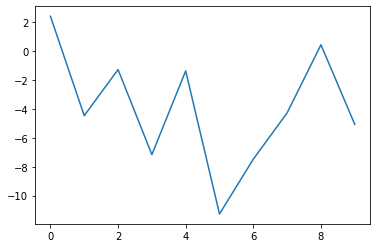

93 0.5889316201210022
94 0.6112947463989258
95 0.49651244282722473
96 0.6242591142654419
97 0.5586840510368347
0 0.5406491160392761
1 0.6534635424613953
2 0.6179652214050293
3 0.6166275143623352
4 0.5025442242622375
5 0.5544924736022949
6 0.6321333646774292
7 0.5697423219680786
8 0.5513930320739746
9 0.6652851104736328
10 0.6246386170387268
11 0.5725075602531433
12 0.5760297775268555
13 0.560829758644104
14 0.5554884672164917
15 0.6060457825660706
16 0.5801318287849426
17 0.6462870836257935
18 0.5760310292243958
19 0.578855574131012
20 0.6304982900619507
21 0.6517418622970581
22 0.5338415503501892
23 0.5445736646652222
24 0.6164349913597107
25 0.6229920983314514
26 0.5872923135757446
27 0.589897096157074
28 0.5738633871078491
29 0.5293315649032593
30 0.5788576006889343
31 0.5728734135627747
32 0.6013678908348083
33 0.5284533500671387
34 0.602910578250885
35 0.6612803936004639
36 0.6153140664100647
37 0.6585957407951355
38 0.5960724353790283
39 0.5916725993156433
40 0.5350301861763
41 0

KeyboardInterrupt: 

In [11]:
from IPython import display
import matplotlib.pyplot as plt

model.train()

while(True):
    for batch_index, batch in enumerate(train_loader):

        x, t = batch
        x = x.to(DEVICE)
        t = t.to(DEVICE)

        model.zero_grad()
        y = model(x, t)

        loss = nn.CrossEntropyLoss()(y, t)
        loss.backward()
        optimizer.step()

        print(batch_index, loss.item())
        
        if step % 10 == 0:
            logger.log('loss', loss.item(), step)

        if step % 1000 == 0:
            if not os.path.exists(save_dir):
                os.mkdir(save_dir)

            path = save_dir + '/' + 'save_' + str(step)
            torch.save({
                'step': step,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()}, path)
            print('saved', path)
            
            '''
            Test
            '''
            correct = []
            for batch_index, batch in enumerate(test_loader):

                    x, t = batch
                    x = x.to(DEVICE)
                    t = t.to(DEVICE)

                    y = model(x, t)
                    _y = y.data.cpu().numpy()
                    _y = np.argmax(_y, axis=1)
                    _t = t.data.cpu().numpy()

                    correct.append((_y == _t))

            correct = np.concatenate(correct)
            precision = np.sum(correct) / len(correct)

            logger.log('test precision', precision, step)

        if step % 100 == 0:
            display.clear_output()
            _y = y.data.cpu().numpy()
            _t = t.data.cpu().numpy()
            print(_t[0])
            plt.plot(_y[0])
            plt.show()
         
        step += 1

In [ ]:
path = save_dir + '/' + 'save_' + str(step)
torch.save({
    'step': step,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()}, path)
print('saved', path)

In [ ]:
!nvidia-smi